In [265]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [266]:
df = pd.read_csv('data.csv')

In [268]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [315]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-315-ba619eaf1a0a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-315-ba619eaf1a0a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-315-ba619eaf1a0a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [270]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [271]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-271-de7e6513462b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-271-de7e6513462b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [272]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [273]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [274]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-274-70dee3a061a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [276]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [277]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [278]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [325]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

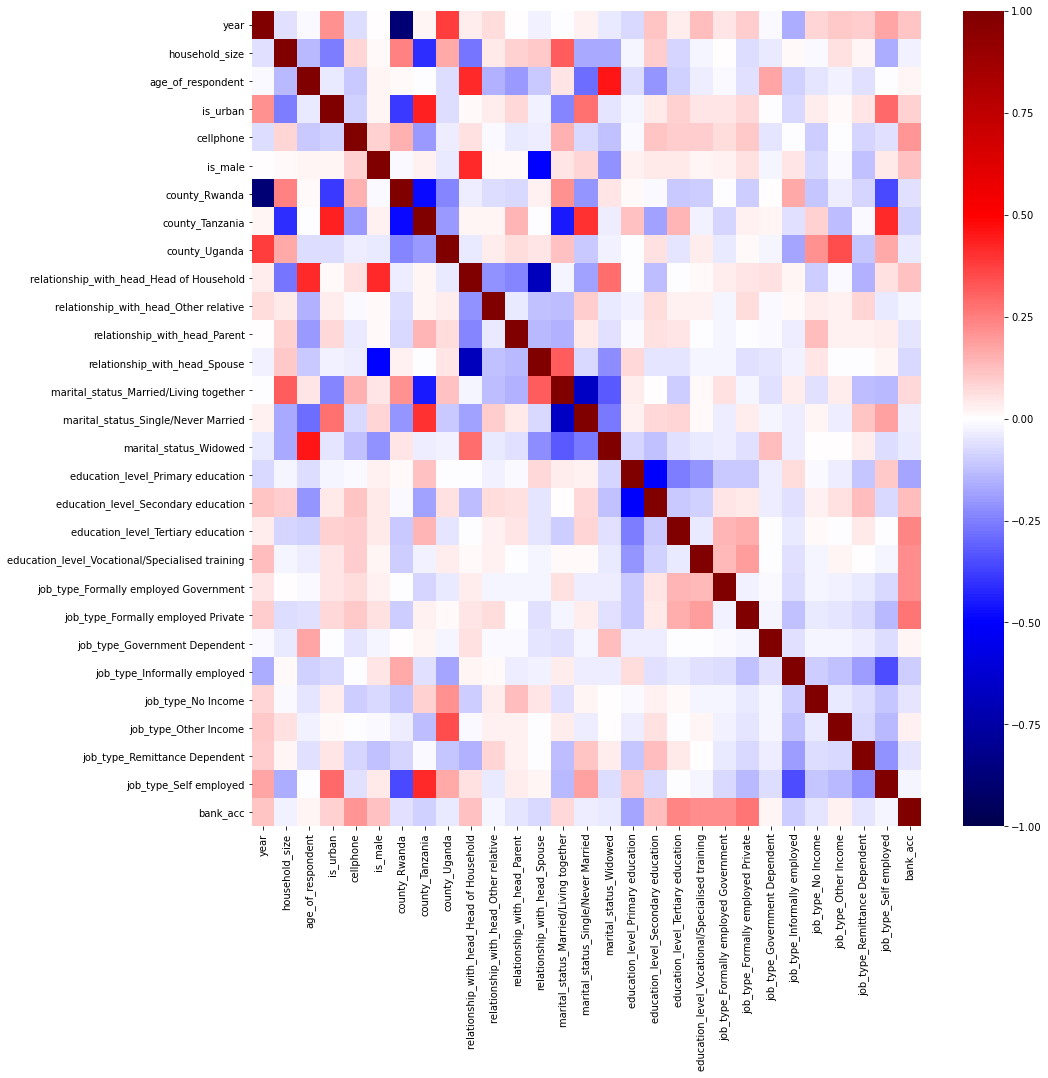

In [279]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_vis.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

<ipython-input-280-b5a040c16efb>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df_vis_cont[df_vis_cont.columns[0:]], ax=ax);


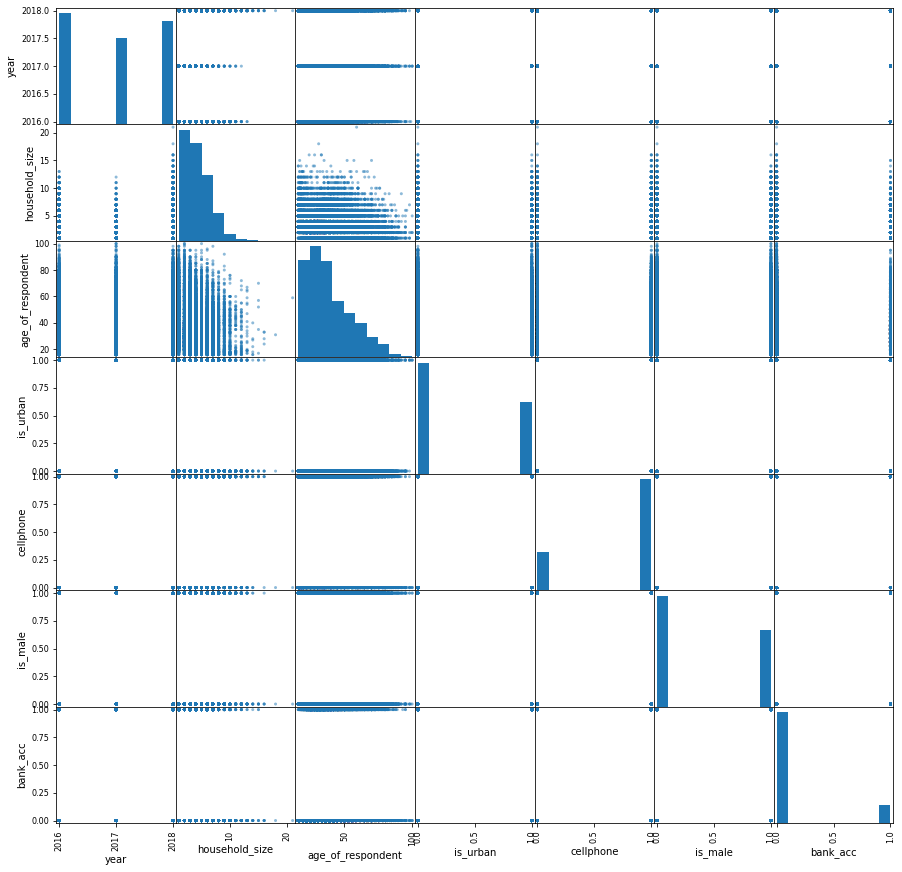

In [280]:
fig, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df_vis_cont[df_vis_cont.columns[0:]], ax=ax);

<ipython-input-281-8032c2cd83a9>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df_vis_cat[df_vis_cat.columns[0:]], ax=ax);


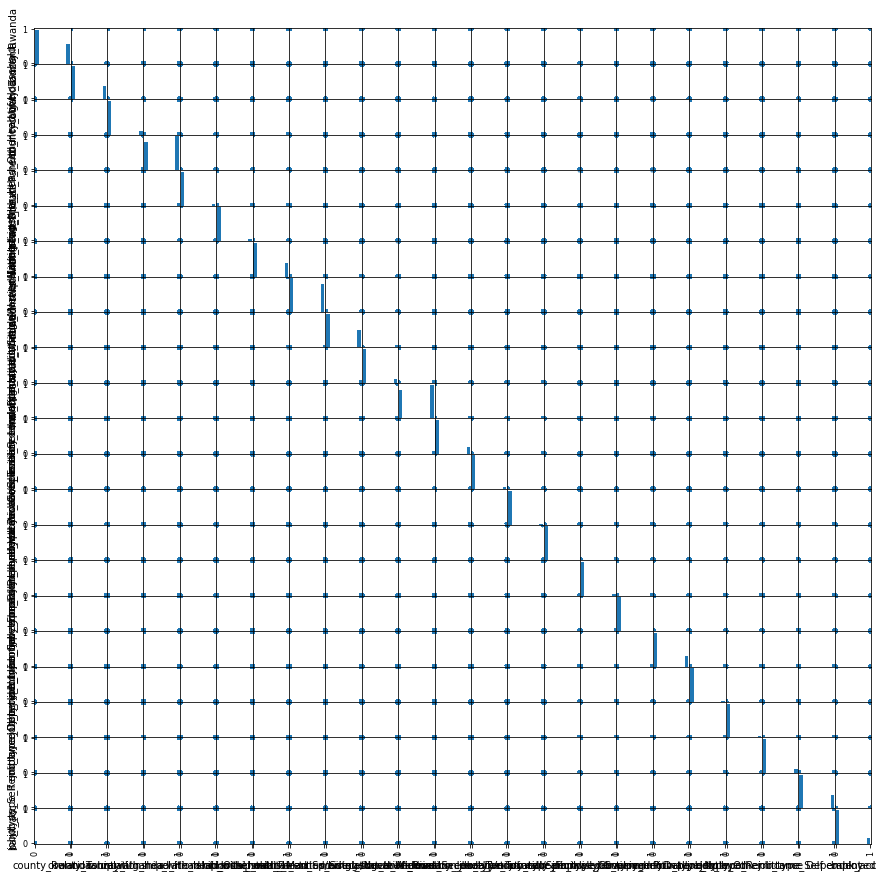

In [281]:
fig, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df_vis_cat[df_vis_cat.columns[0:]], ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

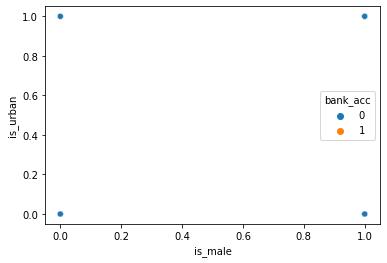

In [282]:
sns.scatterplot(data=df_train,
                x='is_male',
                y='is_urban',
                hue='bank_acc');

In [283]:
#Model on is_male first
lm_1 = sm.Logit(df_train['bank_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [284]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bank_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Jan 2021   Pseudo R-squ.:                 0.01691
Time:                        10:38:15   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1251      0.035    -60.055      0.000      -2.194      -2.056
is_male        0.6779      0.049     13.887      0.000       0.582       0.774
==============================================================================
"""

In [285]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['bank_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [286]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -2.1251
is_male coef:  0.6779


In [287]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['bank_acc']

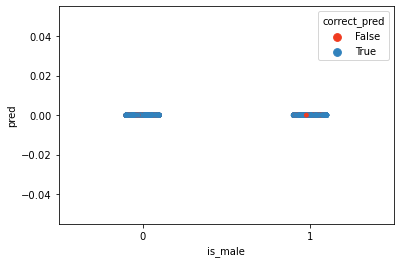

In [291]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [289]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.89331742, 0.10668258],
       [0.80955703, 0.19044297],
       [0.89331742, 0.10668258],
       [0.89331742, 0.10668258],
       [0.80955703, 0.19044297]])

In [290]:
confusion_matrix(df_eval['bank_acc'], df_eval['pred'])

array([[3037,    0],
       [ 492,    0]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

Note it is not predicting because it does not have enough information based on this feature alone (paricularly since this feature is a dummy?)

## Multiple regression
The below analysis is a multiple logistic regression for all features 

In [303]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
x_train1 = scaler.fit_transform(df_train[features])
y_train1 = df_train['bank_acc']

In [304]:
lm_2 = LogisticRegression()  

In [305]:
lm_2.fit(x_train1, y_train1)

LogisticRegression()

In [306]:
x_val1 = scaler.transform(df_val[features])
preds = lm_2.predict(x_val1)

In [307]:
confusion_matrix(df_val['bank_acc'], 
                 preds)

array([[2958,   79],
       [ 324,  168]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2958 | 79|
| **is account (1)** | 324 | 168 |

Based on the above, I believe it is correct to conclude that it is correctly predicting __~88%__ of the observations in the validation sample

Need to understand the __trade off between recall and precision__

In [309]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']])[:, 1]

In [310]:
fpr, tpr, thresholds = roc_curve(df_val['bank_acc'],
                                 df_val['proba_bank'])

In [311]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

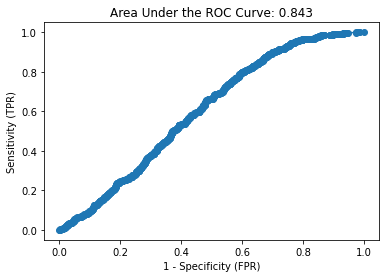

In [312]:
plot_roc(df_val['bank_acc'], lm_2.predict_proba(x_val1)[:, 1])

Need to better understand what this means - refer back to the video

In [314]:
mask = tpr > 0.9
thresholds[mask].max()

0.9857021872096586

## Testing the model on the test set

1. Preparing the test sample

In [317]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-317-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-317-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-317-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [318]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [319]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [320]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [321]:
y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-321-52765b19127d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


2. Testing the model on the test sample

In [322]:
x_test1 = scaler.transform(df_test[features])
preds = lm_2.predict(x_test1)

In [323]:
confusion_matrix(df_test['bank_acc'], 
                 preds)

array([[4898,  149],
       [ 543,  291]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4839 | 149|
| **is account (1)** | 543 | 291 |

As above, does this mean it is correctly interpretting ~87% of the test sample?

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 